In [338]:
import os
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import pytz
import random
from pysolar import solar
import datetime
import reverse_geocoder as rg 
import matplotlib.pyplot as plt
from wwo_hist import retrieve_hist_data

In [339]:
tz = pytz.timezone("Turkey")
now = datetime.datetime.now(tz).replace(microsecond=0,second=0,minute=0)
date_format = "%b %d %Y %H:00:00"
total_minutes_in_year = 60*24*365
total_solar_panel_area = 1
minute_diff = 60


#Turkey's latitude and longitude ranges
min_latitude = 35.9025
max_latitude = 42.0268
min_longitude = 25.9090
max_longitude = 44.5742

In [340]:
def get_altitude_by_location(lat,lon,date):
    return solar.get_altitude(lat, lon, date)

def get_azimuth_by_location(lat,lon,date):
    return solar.get_azimuth(lat, lon, date)

def get_radiation_by_location(lat,lon,date):
    return solar.radiation.get_radiation_direct(date, get_altitude_by_location(lat,lon,date))

In [341]:
def get_solar_info(lat,lon,date):
    return get_altitude_by_location(lat,lon,date),\
            get_azimuth_by_location(lat,lon,date),\
            get_radiation_by_location(lat,lon,date)




In [342]:
def get_location(coordinates):
    return rg.search(coordinates) 

In [348]:
def get_random_location(min_lat,max_lat,min_lon,max_lon):
     return random.uniform(min_lat,max_lat), random.uniform(min_lon,max_lon)

location = get_random_location(min_latitude,max_latitude,min_longitude,max_longitude)
print("Coordinates", location)
result = get_location(location)
print("City name is" , result[0]["admin1"], "\nCounty name is" ,result[0]["name"])
latitude, longitude = location[0],location[1]

Coordinates (37.22092573844832, 28.35647141132882)
City name is Mugla 
County name is Mugla


In [349]:
dates = []
solar_info = []
for min_diff in range(total_minutes_in_year,0,minute_diff*-1):
    past_date = now - datetime.timedelta(minutes=min_diff)
    dates.append(past_date)
    solar_info.append(get_solar_info(latitude,longitude,past_date))

/Users/egehangunduz/opt/anaconda3/lib/python3.7/site-packages/pysolar/solartime.py:112: UserWarning: I don't know about leap seconds after 2018
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


In [350]:
df = pd.concat([pd.DataFrame(dates,columns=["date"]),\
                pd.DataFrame(solar_info,columns=["altitude","azimuth","solar_radiation"])],\
               axis=1)

In [351]:
df.set_index("date",inplace=True)

In [352]:
frequency = 1
start_date = now - datetime.timedelta(minutes=total_minutes_in_year)
end_date = now
api_key = os.environ['WWO_API_KEY'] 
location_list = [str(latitude) +  "," + str(longitude)]

In [375]:
hist_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                store_df = True)



Retrieving weather data for 37.22092573844832,28.35647141132882


Currently retrieving data for 37.22092573844832,28.35647141132882: from 2018-12-22 to 2018-12-31
Time elapsed (hh:mm:ss.ms) 0:00:01.355498
Currently retrieving data for 37.22092573844832,28.35647141132882: from 2019-01-01 to 2019-01-31
Time elapsed (hh:mm:ss.ms) 0:00:02.679179
Currently retrieving data for 37.22092573844832,28.35647141132882: from 2019-02-01 to 2019-02-28
Time elapsed (hh:mm:ss.ms) 0:00:03.720393
Currently retrieving data for 37.22092573844832,28.35647141132882: from 2019-03-01 to 2019-03-31
Time elapsed (hh:mm:ss.ms) 0:00:04.884321
Currently retrieving data for 37.22092573844832,28.35647141132882: from 2019-04-01 to 2019-04-30
Time elapsed (hh:mm:ss.ms) 0:00:07.049639
Currently retrieving data for 37.22092573844832,28.35647141132882: from 2019-05-01 to 2019-05-31
Time elapsed (hh:mm:ss.ms) 0:00:08.359344
Currently retrieving data for 37.22092573844832,28.35647141132882: from 2019-06-01 to 2019-06-30
T

In [376]:
historical = pd.DataFrame(hist_data[0])

In [377]:
historical.set_index("date_time",inplace=True)

In [378]:
historical.index = historical.index.tz_localize(tz)

In [379]:
data = pd.merge(df,historical,left_index=True,right_index=True)

In [380]:
data.cloudcover = data.cloudcover.astype(float)
data.sunHour = data.sunHour.astype(float)

In [381]:
data["overall_solar_radiation"] = data.solar_radiation*((100-data.cloudcover)/100)

In [382]:
def convert_sun(time):
    splitted = time.split(" ")
    hour = int(splitted[0].split(":")[0])
    minute = splitted[0].split(":")[1]
    am_pm = splitted[1]
    if am_pm == "PM":
        hour += 12
    return str(hour) + ":" + str(minute)


In [383]:
data.sunset = data.sunset.apply(convert_sun)
data.sunrise = data.sunrise.apply(convert_sun)

In [384]:
def remove_night_data(df):
    return df[df.solar_radiation != 0]

In [385]:
data = remove_night_data(data)

In [386]:
data["overall_jm2_solar_radiation"] = data.overall_solar_radiation * 3600

In [387]:
def group_by_freq(data,freq):
    return data\
                    .groupby(pd.Grouper(freq=freq))["overall_jm2_solar_radiation"]\
                    .agg({"overall_jm2_solar_radiation":"sum"})

daily_total_solar_data = group_by_freq(data,"D")
weekly_total_solar_data = group_by_freq(data,"W")
monthly_total_solar_data = group_by_freq(data,"M")

/Users/egehangunduz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  after removing the cwd from sys.path.


In [397]:
def calculate_kwh(total_solar_data):
    total_solar_data["total_kwh"] = total_solar_data.overall_jm2_solar_radiation/3600/1000
    return total_solar_data

daily_total_solar_data = calculate_kwh(daily_total_solar_data)
weekly_total_solar_data = calculate_kwh(weekly_total_solar_data)
monthly_total_solar_data = calculate_kwh(monthly_total_solar_data)

/Users/egehangunduz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/Users/egehangunduz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/Users/egehangunduz/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


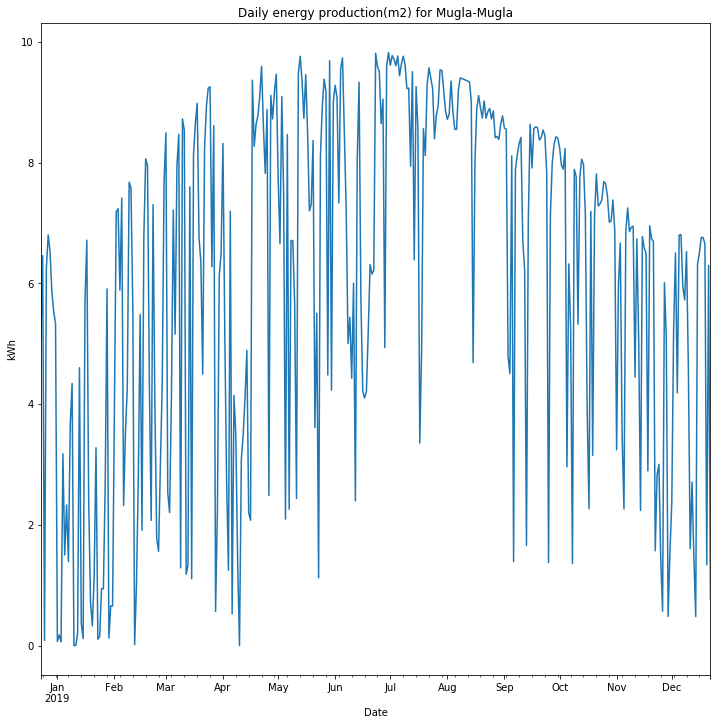

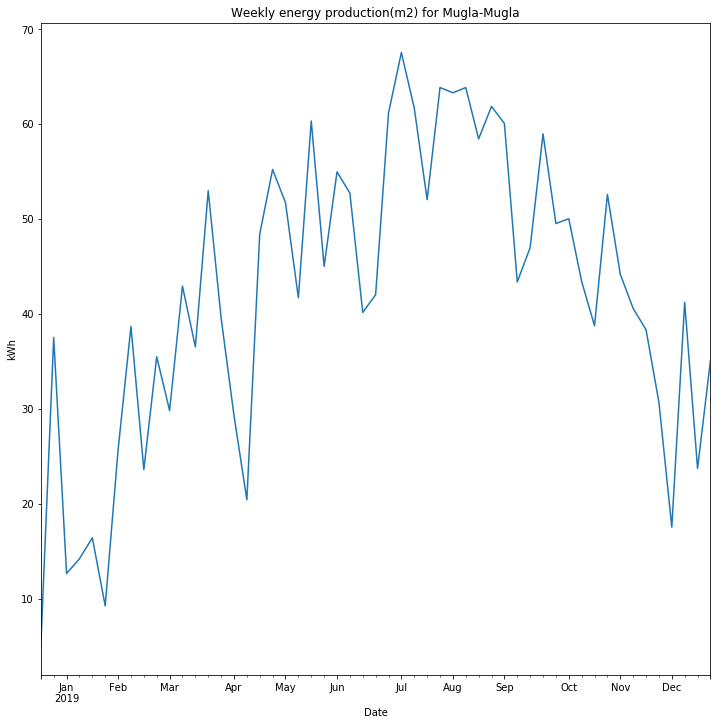

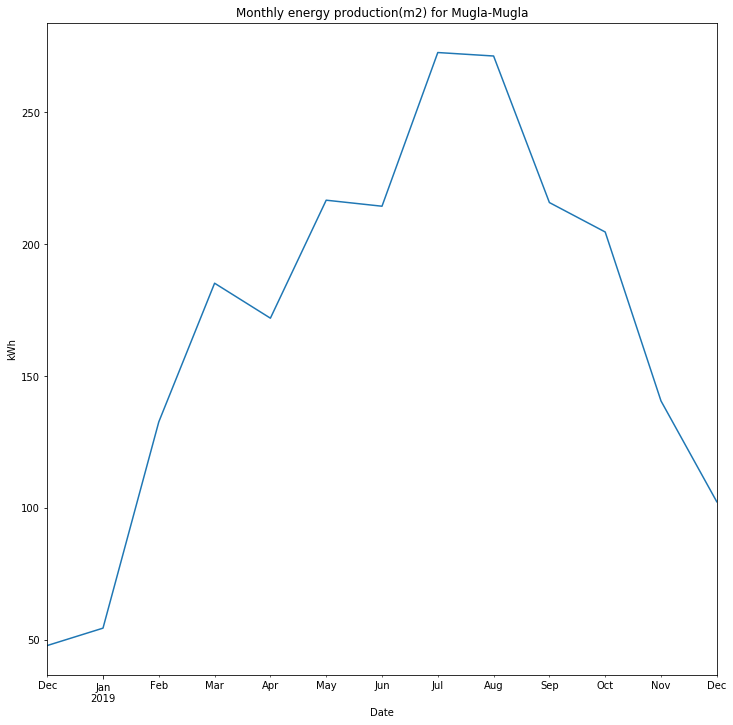

In [398]:
def plot_data(data,frequency,result):
    plt.figure(figsize=(12,12))
    data.daily_total_kwh.plot()
    plt.title( str(frequency)+" energy production(m2) for " + result[0]["admin1"]  + "-" + result[0]["name"])
    plt.xlabel("Date")
    plt.ylabel("kWh")
    
plot_data(daily_total_solar_data,"Daily",result)
plot_data(weekly_total_solar_data,"Weekly",result)
plot_data(monthly_total_solar_data,"Monthly",result)

In [400]:
print("Yearly total solar energy production for m2: %4.2f kWh" %(total_solar_data.daily_total_kwh.sum()))

Yearly total solar energy production for m2: 2231.37 kWh
